## Combined Dataset SOC Prediction - Long Short Term Memory Networks (LSTM)
Uses discharge cycles from both the LG and Panasonic datasets.

LG 18650HG2 Li-ion Battery Data - https://data.mendeley.com/datasets/cp3473x7xv/3

Panasonic 18650PF Li-ion Battery Data - https://data.mendeley.com/datasets/wykht8y7tg/1

Kollmeyer, Philip; Vidal, Carlos; Naguib, Mina; Skells, Michael  (2020), “LG 18650HG2 Li-ion Battery Data and Example Deep Neural Network xEV SOC Estimator Script”, Mendeley Data, V3, doi: 10.17632/cp3473x7xv.3

Kollmeyer, Phillip (2018), “Panasonic 18650PF Li-ion Battery Data”, Mendeley Data, V1, doi: 10.17632/wykht8y7tg.1

In [1]:
import os
import sys
import IPython
import IPython.display
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import collections
from datetime import datetime, timedelta

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras.layers.core import Dense
from tensorflow.keras import layers

cell_type = "combined"
model_type = "lstm_model"
base_path = '../../'

sys.path.append(base_path)
from training import utils

panasonic_data_path = base_path + 'datasets/Panasonic_18650PF'
lg_data_path = base_path + 'datasets/LG_18650HG2'
pre_trained_path = base_path + 'pre-trained/' + cell_type + '_' + model_type

resample_1hz = False
vi_averages = True

2023-03-23 08:35:34.452866: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-23 08:35:35.983756: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-23 08:35:35.983796: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-23 08:35:36.258345: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-23 08:35:40.427277: W tensorflow/stream_executor/platform/de

## Panasonic Test, Train Processing

In [2]:
panasonic_test_temps = ['n10degC', '0degC', '10degC', '25degC']
panasonic_test_discharge_cycles = ['US06', 'LA92', 'NN']

panasonic_train_temps = ['n10degC', '0degC', '10degC', '25degC']
panasonic_train_discharge_cycles = ['UDDS', 'HWFET', 'HWFT']

panasonic_train_files = utils.panasonic_get_files(panasonic_data_path,
                                                  panasonic_train_discharge_cycles, 
                                                  panasonic_train_temps)

panasonic_test_files = utils.panasonic_get_files(panasonic_data_path, 
                                                 panasonic_test_discharge_cycles,
                                                 panasonic_test_temps)

for file in panasonic_train_files:
    if "UDDS_LA92" in file or "LA92_NN" in file:
        panasonic_train_files.remove(file)

for file in panasonic_test_files:
    if "UDDS_LA92" in file or "LA92_NN" in file:
        panasonic_test_files.remove(file)

panasonic_train, panasonic_train_norm = utils.panasonic_create_dataset(panasonic_train_files,
                                                                       panasonic_train_discharge_cycles, 
                                                                       vi_averages, 
                                                                       resample_1hz)

panasonic_test, panasonic_test_norm = utils.panasonic_create_dataset(panasonic_test_files, 
                                                                     panasonic_test_discharge_cycles, 
                                                                     vi_averages, 
                                                                     resample_1hz)

../../datasets/Panasonic_18650PF/0degC/Drive cycles/06-02-17_10.43 0degC_HWFET_Pan18650PF.csv 59854
../../datasets/Panasonic_18650PF/0degC/Drive cycles/06-02-17_17.14 0degC_UDDS_Pan18650PF.csv 128522
../../datasets/Panasonic_18650PF/10degC/Drive Cycles/03-27-17_09.06 10degC_HWFET_Pan18650PF.csv 70406
../../datasets/Panasonic_18650PF/10degC/Drive Cycles/03-27-17_09.06 10degC_UDDS_Pan18650PF.csv 210465
../../datasets/Panasonic_18650PF/25degC/Drive cycles/03-20-17_05.56 25degC_HWFTa_Pan18650PF.csv 75955
../../datasets/Panasonic_18650PF/25degC/Drive cycles/03-20-17_19.27 25degC_HWFTb_Pan18650PF.csv 75811
../../datasets/Panasonic_18650PF/25degC/Drive cycles/03-21-17_00.29 25degC_UDDS_Pan18650PF.csv 224187
../../datasets/Panasonic_18650PF/n10degC/Drive Cycles/06-07-17_08.39 n10degC_HWFET_Pan18650PF.csv 51385
../../datasets/Panasonic_18650PF/n10degC/Drive Cycles/06-07-17_08.39 n10degC_UDDS_Pan18650PF.csv 109717
../../datasets/Panasonic_18650PF/0degC/Drive cycles/06-01-17_10.36 0degC_LA92_Pan1

## LG Test, Train Processing

In [3]:
lg_charge_cycles = ['Charge']

lg_test_temps = ['n10degC', '0degC', '10degC', '25degC']
lg_test_discharge_cycles = ['Mixed1', 'Mixed2', 'Mixed3', 'Mixed4', 'LA92', 'US06']

lg_train_temps = ['n10degC', '0degC', '10degC', '25degC']
lg_train_discharge_cycles = ['Mixed5', 'Mixed6', 'Mixed7', 'Mixed8', 'UDDS', 'HWFET']

lg_train_files = utils.lg_get_files(lg_data_path, 
                                    lg_train_discharge_cycles, 
                                    lg_charge_cycles, 
                                    lg_train_temps)

lg_test_files = utils.lg_get_files(lg_data_path, 
                                   lg_test_discharge_cycles,
                                   lg_charge_cycles, 
                                   lg_test_temps)

lg_train, lg_train_norm = utils.lg_create_dataset(lg_train_files, 
                                                  lg_train_discharge_cycles, 
                                                  lg_charge_cycles, 
                                                  vi_averages, 
                                                  resample_1hz)

lg_test, lg_test_norm = utils.lg_create_dataset(lg_test_files, 
                                                lg_test_discharge_cycles, 
                                                lg_charge_cycles, 
                                                vi_averages, 
                                                resample_1hz)

../../datasets/LG_18650HG2/25degC/551_UDDS.csv 159646
../../datasets/LG_18650HG2/25degC/551_HWFET.csv 6002
../../datasets/LG_18650HG2/25degC/552_Mixed5.csv 72184
../../datasets/LG_18650HG2/25degC/552_Mixed6.csv 78106
../../datasets/LG_18650HG2/25degC/552_Mixed7.csv 73235
../../datasets/LG_18650HG2/25degC/552_Mixed8.csv 85915
../../datasets/LG_18650HG2/10degC/571_Mixed5.csv 67174
../../datasets/LG_18650HG2/10degC/571_Mixed6.csv 73921
../../datasets/LG_18650HG2/10degC/571_Mixed7.csv 69325
../../datasets/LG_18650HG2/10degC/571_Mixed8.csv 81422
../../datasets/LG_18650HG2/10degC/576_UDDS.csv 148898
../../datasets/LG_18650HG2/10degC/576_HWFET.csv 52878
../../datasets/LG_18650HG2/0degC/589_UDDS.csv 140435
../../datasets/LG_18650HG2/0degC/589_HWFET.csv 49678
../../datasets/LG_18650HG2/0degC/590_Mixed5.csv 64995
../../datasets/LG_18650HG2/0degC/590_Mixed6.csv 62483
../../datasets/LG_18650HG2/0degC/590_Mixed7.csv 61540
../../datasets/LG_18650HG2/0degC/590_Mixed8.csv 75838
../../datasets/LG_18650

## Panasonic, LG Train Test Stats

In [4]:
panasonic_test.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Voltage,854853.0,3.605589,0.258249,2.486610,3.434290,3.604780,3.795860,4.228380
Current,854853.0,-1.066715,2.370632,-20.822170,-2.040730,-0.267030,-0.000820,9.733000
Temperature,854853.0,13.553624,11.551254,-7.664535,3.505449,12.690260,26.460110,32.972070
Power,854853.0,-3.549388,8.102271,-53.564019,-7.255578,-0.978608,-0.003120,36.107842
Capacity,854853.0,0.461482,0.278970,0.000000,0.218178,0.464071,0.704083,0.955254
Voltage Average,854853.0,3.625765,0.225778,3.037885,3.457230,3.619758,3.799680,4.101673
Current Average,854853.0,-1.104712,0.568532,-3.013599,-1.331028,-0.885313,-0.747745,-0.248353
Power Average,854853.0,-3.701265,1.847476,-9.184242,-4.287784,-2.994865,-2.611487,-0.721010


In [5]:
panasonic_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Voltage,961311.0,3.626947,0.247219,2.498190,3.457450,3.623440,3.815160,4.202000
Current,961311.0,-0.771463,1.119442,-7.529230,-1.505030,-0.619810,-0.071050,5.542700
Temperature,961311.0,12.336561,12.469933,-9.262373,1.796085,11.416263,26.045400,29.833780
Power,961311.0,-2.706822,3.964084,-18.938348,-5.415175,-2.276245,-0.276622,19.280503
Capacity,961311.0,0.479601,0.283093,0.000000,0.237968,0.490041,0.723031,0.968828
Voltage Average,961311.0,3.642537,0.235403,3.021438,3.470302,3.637816,3.826879,4.111014
Current Average,961311.0,-0.792987,0.440957,-1.925466,-1.237759,-0.620225,-0.403920,-0.192880
Power Average,961311.0,-2.795570,1.538067,-5.870924,-4.377887,-2.193028,-1.421321,-0.533335


In [6]:
lg_test.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Time Stamp,,,,,,,,
Voltage,1237320.0,3.657962,0.270252,2.786280,3.485410,3.664130,3.857300,4.209560
Current,1237320.0,-1.391509,2.783160,-18.098280,-2.745650,-0.881160,-0.071510,6.004720
Temperature,1237320.0,8.054045,12.693492,-9.884900,-0.315480,9.464270,23.976150,26.815430
Power,1237320.0,-4.753100,9.690834,-50.872124,-9.762223,-3.251054,-0.274570,25.184354
Capacity,1237320.0,0.485984,0.269577,0.000000,0.269068,0.475913,0.708232,0.978041
Voltage Average,1237320.0,3.694402,0.231613,3.089298,3.516941,3.687397,3.882260,4.168740
Current Average,1237320.0,-1.352892,0.764777,-3.810302,-1.774988,-1.183896,-0.807518,1.225048
Power Average,1237320.0,-4.688044,2.582078,-11.886129,-6.328998,-4.183578,-2.773709,5.168611


In [7]:
lg_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Time Stamp,,,,,,,,
Voltage,1572498.0,3.679938,0.255575,2.790660,3.504000,3.689750,3.881230,4.200630
Current,1572498.0,-1.126147,2.225483,-17.998670,-2.229720,-0.771340,-0.097060,6.002170
Temperature,1572498.0,7.073696,12.102399,-10.095220,-0.420630,9.148790,23.765830,26.289630
Power,1572498.0,-3.904285,7.810726,-50.875355,-8.075737,-2.834497,-0.386533,25.183334
Capacity,1572498.0,0.485173,0.266602,0.000000,0.258357,0.484660,0.718736,0.955909
Voltage Average,1572498.0,3.708077,0.225078,3.049703,3.524830,3.717430,3.902546,4.110379
Current Average,1572498.0,-1.112088,0.681626,-3.711826,-1.459862,-0.935125,-0.519282,-0.275509
Power Average,1572498.0,-3.897505,2.312431,-11.434436,-4.972673,-3.264254,-1.870385,-1.089597


## Merge Panasonic and LG datasets

In [8]:
merged_train = pd.concat([lg_train, panasonic_train], ignore_index=True)
merged_test = pd.concat([lg_test, panasonic_test], ignore_index=True)

# merged_train_norm = utils.normalization(merged_train, minmax_norm=True)
# merged_test_norm = utils.normalization(merged_test, minmax_norm=True)
merged_train_norm = pd.concat([lg_train_norm, panasonic_train_norm], ignore_index=True)
merged_test_norm = pd.concat([lg_test_norm, panasonic_test_norm], ignore_index=True)

In [9]:
merged_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Voltage,2533809.0,3.659834,0.253743,2.498190,3.484470,3.664610,3.855690,4.202000
Current,2533809.0,-0.991582,1.891767,-17.998670,-1.856820,-0.693310,-0.074310,6.002170
Temperature,2533809.0,9.070393,12.506635,-10.095220,-0.105160,9.464270,23.976150,29.833780
Power,2533809.0,-3.449975,6.645374,-50.875355,-6.609287,-2.528493,-0.278195,25.183334
Capacity,2533809.0,0.483059,0.272989,0.000000,0.251019,0.486522,0.720684,0.968828
Voltage Average,2533809.0,3.683212,0.231247,3.021438,3.508219,3.684577,3.877203,4.111014
Current Average,2533809.0,-0.991023,0.621360,-3.711826,-1.339376,-0.839673,-0.492614,-0.192880
Power Average,2533809.0,-3.479438,2.121793,-11.434436,-4.670912,-3.009527,-1.759833,-0.533335


In [10]:
merged_test.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Voltage,2092173.0,3.636563,0.266659,2.486610,3.461180,3.640960,3.831510,4.228380
Current,2092173.0,-1.258799,2.627310,-20.822170,-2.474910,-0.578170,-0.010620,9.733000
Temperature,2092173.0,10.301149,12.534671,-9.884900,0.105160,9.884900,24.081300,32.972070
Power,2092173.0,-4.261269,9.094680,-53.564019,-8.863867,-2.134892,-0.039697,36.107842
Capacity,2092173.0,0.475972,0.273719,0.000000,0.251404,0.471780,0.705876,0.978041
Voltage Average,2092173.0,3.666357,0.231716,3.037885,3.494506,3.662161,3.845094,4.168740
Current Average,2092173.0,-1.251487,0.702037,-3.810302,-1.504988,-1.084387,-0.764728,1.225048
Power Average,2092173.0,-4.284850,2.360692,-11.886129,-4.943874,-3.819373,-2.662047,5.168611


## LSTM MODEL TRAINING

In [11]:
# create lstm dataset
steps = 300

train_x, train_y = utils.create_lstm_dataset(merged_train_norm,steps)
test_x, test_y = utils.create_lstm_dataset(merged_test_norm,steps)

train_y = utils.keep_only_y_end(train_y, steps)
test_y = utils.keep_only_y_end(test_y, steps)

In [12]:
# LSTM model architecture - https://github.com/KeiLongW/battery-state-estimation
opt = tf.keras.optimizers.Adam(lr=0.00001)

lstm_model = Sequential()
lstm_model.add(LSTM(256, activation='selu',
                    return_sequences=True,
                    input_shape=(train_x.shape[1], train_x.shape[2])))
lstm_model.add(LSTM(256, activation='selu', return_sequences=False))
lstm_model.add(Dense(256, activation='selu'))
lstm_model.add(Dense(128, activation='selu'))
lstm_model.add(Dense(1, activation='linear'))
lstm_model.summary()

lstm_model.compile(optimizer=opt, loss='huber', metrics=['mse', 'mae', 'mape', tf.keras.metrics.RootMeanSquaredError(name='rmse')])

es = EarlyStopping(monitor='val_loss', patience=50)

/home/ap_surface/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
2023-03-23 08:41:56.772027: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-23 08:41:56.773837: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-23 08:41:56.773998: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (AP-Surface): /proc/driver/nvidia/version does not exist
2023-03-23 08:41:56.778122: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 300, 256)          268288    
                                                                 
 lstm_1 (LSTM)               (None, 256)               525312    
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 892,417
Trainable params: 892,417
Non-trainable params: 0
_________________________________________________________________


In [13]:
history = lstm_model.fit(
    train_x, 
    train_y, 
    epochs=75, batch_size=32, 
    verbose=1, validation_split=0.2,
    callbacks = [es])

Epoch 1/75
212/212 [==============================] - 351s 2s/step - loss: 0.0100 - mse: 0.0201 - mae: 0.0739 - mape: 982748.7500 - rmse: 0.1417 - val_loss: 0.0030 - val_mse: 0.0061 - val_mae: 0.0567 - val_mape: 3781038.2500 - val_rmse: 0.0779
Epoch 2/75
212/212 [==============================] - 358s 2s/step - loss: 0.0021 - mse: 0.0041 - mae: 0.0278 - mape: 851175.8750 - rmse: 0.0643 - val_loss: 0.0022 - val_mse: 0.0044 - val_mae: 0.0463 - val_mape: 3090735.5000 - val_rmse: 0.0667
Epoch 3/75
212/212 [==============================] - 358s 2s/step - loss: 0.0020 - mse: 0.0039 - mae: 0.0263 - mape: 807461.5000 - rmse: 0.0628 - val_loss: 0.0019 - val_mse: 0.0038 - val_mae: 0.0394 - val_mape: 3218186.5000 - val_rmse: 0.0615
Epoch 4/75
212/212 [==============================] - 363s 2s/step - loss: 0.0019 - mse: 0.0039 - mae: 0.0253 - mape: 744694.0000 - rmse: 0.0624 - val_loss: 0.0025 - val_mse: 0.0051 - val_mae: 0.0505 - val_mape: 3335324.2500 - val_rmse: 0.0711
Epoch 5/75
212/212 [====

## SAVE MODEL, EVALUATE

In [14]:
lstm_model.save(pre_trained_path)

# load pre-trained model
# model = tf.keras.models.load_model(pre_trained_path)

INFO:tensorflow:Assets written to: ../../pre-trained/combined_lstm_model/assets


In [15]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mse,mae,mape,rmse,val_loss,val_mse,val_mae,val_mape,val_rmse,epoch
70,0.001600,0.003199,0.021571,624860.56250,0.056563,0.001628,0.003257,0.035642,3083732.25,0.057067,70
71,0.001315,0.002630,0.021628,603490.31250,0.051286,0.001388,0.002776,0.031697,2503644.75,0.052687,71
72,0.001233,0.002466,0.022741,617133.75000,0.049660,0.001574,0.003149,0.038506,2362506.50,0.056113,72
73,0.001012,0.002025,0.022940,416055.78125,0.044999,0.001055,0.002110,0.029459,2190788.50,0.045931,73
74,0.000723,0.001446,0.018582,447818.03125,0.038031,0.001247,0.002494,0.031910,2541493.75,0.049936,74


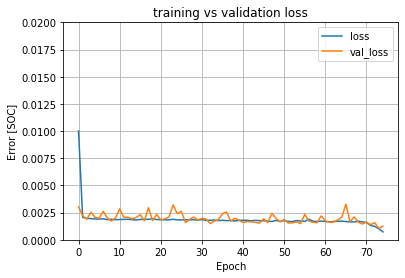

In [17]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 0.02])
    plt.xlabel('Epoch') 
    plt.ylabel('Error [SOC]')
    plt.title('training vs validation loss')
    plt.legend()
    plt.grid(True)
    
plot_loss(history)

218/218 - 118s - loss: 0.0019 - mse: 0.0038 - mae: 0.0373 - mape: 1341130.8750 - rmse: 0.0618 - 118s/epoch - 542ms/step
218/218 [==============================] - 117s 536ms/step


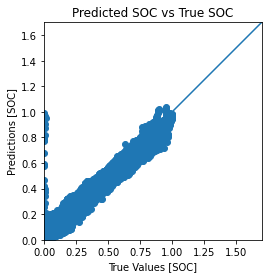

In [18]:
test_results = lstm_model.evaluate(test_x, test_y, verbose=2)
test_predictions = lstm_model.predict(test_x).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_y, test_predictions)
plt.xlabel('True Values [SOC]')
plt.ylabel('Predictions [SOC]')
lims = [0, 1.7]
plt.xlim(lims)
plt.ylim(lims)
plt.title('Predicted SOC vs True SOC')
_ = plt.plot(lims, lims)

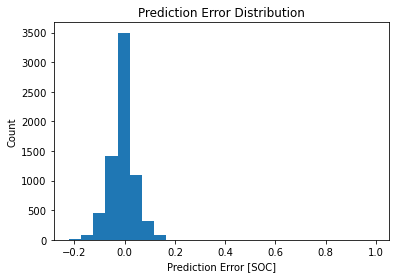

In [19]:
error = test_predictions - test_y.flatten()
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [SOC]')
plt.title('Prediction Error Distribution')
_ = plt.ylabel('Count')

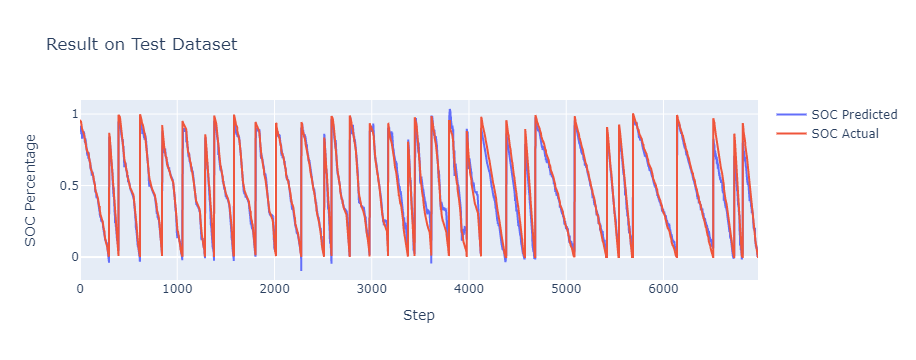

In [35]:
import plotly.graph_objects as go

cycle_num = 0
steps_num = 10000
step_index = np.arange(cycle_num*steps_num, (cycle_num+1)*steps_num)

fig = go.Figure()
fig.add_trace(go.Scatter(x=step_index, y=test_predictions.flatten()[cycle_num*steps_num:(cycle_num+1)*steps_num],
                    mode='lines', name='SOC Predicted'))
fig.add_trace(go.Scatter(x=step_index, y=test_y.flatten()[cycle_num*steps_num:(cycle_num+1)*steps_num],
                    mode='lines', name='SOC Actual'))
fig.update_layout(title='Result on Test Dataset',
                  xaxis_title='Step',
                  yaxis_title='SOC Percentage')
fig.show()